## Predicted Network Headway State as Passenger On-Time Classifier
Unsupervised clustering for network-wide on-time statistic, classification by k-nearest neighbor in autoencoded space

In [3]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model, load_model
from keras.layers import Input, Dense
from sklearn import metrics
from keras import backend as K
import pickle

In [4]:
# Passenger card-swipe derived data
psngr = pd.read_csv('../data/08-state.csv',nrows=10000)

In [6]:
#list(psngr)

In [5]:
# load % OTP of current in-flight trips for 3 months overlapping predicted HDW state
OTP_05 = pd.read_csv('../data/05-state.csv', usecols=['StartTime','InflightOTP'])
OTP_05.rename(columns={'StartTime':'datetime'},inplace=True)
OTP_05['datetime'] = pd.to_datetime(OTP_05['datetime'])

In [6]:
OTP_08 = pd.read_csv('../data/08-state.csv', usecols=['StartTime','InflightOTP'])
OTP_08.rename(columns={'StartTime':'datetime'},inplace=True)
OTP_08['datetime'] = pd.to_datetime(OTP_08['datetime'])

In [7]:
OTP_10 = pd.read_csv('../data/10-state.csv', usecols=['StartTime','InflightOTP'])
OTP_10.rename(columns={'StartTime':'datetime'},inplace=True)
OTP_10['datetime'] = pd.to_datetime(OTP_10['datetime'])

In [10]:
# InflightOTP -- num late / (tot num + 1) in system at current time, 'late' as defined by WMATA standard
OTP_08.head()

,InflightOTP,datetime
0,0.0,2015-08-01 04:01:00
1,0.0,2015-08-01 04:02:00
2,0.0,2015-08-01 04:03:00
3,0.0,2015-08-01 04:04:00
4,0.0,2015-08-01 04:05:00


In [7]:
f_name = '../data/pred_vec_30_lrg.pkl'
f_obj = open(f_name,'rb')
pred_vec_30 = pickle.load(f_obj)
f_obj.close()
f_name = '../data/tot_time_30_lrg.pkl'
f_obj = open(f_name,'rb')
tt = pickle.load(f_obj)
f_obj.close()

In [8]:
dtt_0 = pd.to_datetime('1/1/2015 0:00')
dtt = []
for i in range(len(tt)):
    dtt.append(dtt_0+pd.to_timedelta(tt[i],unit='m'))
              #pd.to_datetime(tt[i], unit='s')

In [56]:
# obtain header for pred HDW file
f = open('../data/cat_train_HDW_MMAO15.csv')
header = f.readline()

# write pred HDW file
g = open('../data/cat_train_HDW_pred30_MMAO15.csv','w')
g.write(header)
for i, hdw_vec in enumerate(pred_vec_30):
    row = ''
    row = row + str(dtt[i]) + ','
    row = row + str(tt[i]) + ','
    for j in hdw_vec:
        row = row + str(hdw_vec[j]) + ','
    g.write(row[:-1]+'\n')
f.close()
g.close()

In [8]:
# load network train-movement state vector: seq2seq predicted headway states
HDW_vec = pd.read_csv('../data/cat_train_HDW_pred30_MMAO15.csv')
HDW_vec.tail()

,datetime,tot_min,A01-1_Headway_0,A01-1_Headway_1,A01-1_Headway_2,A01-2_Headway_0,A01-2_Headway_1,A01-2_Headway_2,A02-1_Headway_0,A02-1_Headway_1,...,N02-2_Headway_2,N03-1_Headway_0,N03-1_Headway_1,N03-1_Headway_2,N03-2_Headway_0,N03-2_Headway_1,N03-2_Headway_2,N04-1_Headway_0,N04-1_Headway_1,N04-1_Headway_2
65014,2015-08-15 14:17:00,326297.0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
65015,2015-08-15 14:18:00,326298.0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
65016,2015-08-15 14:19:00,326299.0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
65017,2015-08-15 14:20:00,326300.0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
65018,2015-08-15 14:21:00,326301.0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [9]:
HDW_vec['datetime'] = pd.to_datetime(HDW_vec['datetime'])

In [10]:
# merge OTP with HDW state, inner product
HDW_OTP_05 = pd.merge(HDW_vec, OTP_05, on='datetime', how='inner')

In [11]:
HDW_OTP_08 = pd.merge(HDW_vec, OTP_08, on='datetime', how='inner')

In [12]:
HDW_OTP_10 = pd.merge(HDW_vec, OTP_10, on='datetime', how='inner')

In [13]:
HDW_OTP = pd.concat([HDW_OTP_05, HDW_OTP_08, HDW_OTP_10])

In [14]:
len(HDW_OTP)

38588

In [15]:
HDW_OTP.head()

,datetime,tot_min,A01-1_Headway_0,A01-1_Headway_1,A01-1_Headway_2,A01-2_Headway_0,A01-2_Headway_1,A01-2_Headway_2,A02-1_Headway_0,A02-1_Headway_1,...,N03-1_Headway_0,N03-1_Headway_1,N03-1_Headway_2,N03-2_Headway_0,N03-2_Headway_1,N03-2_Headway_2,N04-1_Headway_0,N04-1_Headway_1,N04-1_Headway_2,InflightOTP
0,2015-05-01 05:59:00,173159.0,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0.349845
1,2015-05-01 06:00:00,173160.0,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0.347046
2,2015-05-01 06:01:00,173161.0,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0.342942
3,2015-05-01 06:02:00,173162.0,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0.336222
4,2015-05-01 06:03:00,173163.0,0,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,1,1,0.329336


In [16]:
OTPs = HDW_OTP['InflightOTP'].as_matrix()

In [17]:
OTPs

array([ 0.34984472,  0.34704641,  0.34294205, ...,  0.62960731,
        0.62866647,  0.63265716])

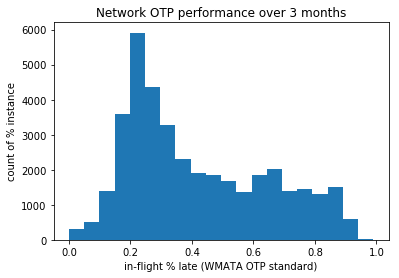

In [61]:
plt.hist(OTPs, bins = 20)
#plt.yscale('log')
plt.title('Network OTP performance over 3 months')
plt.ylabel('count of % instance')
plt.xlabel('in-flight % late (WMATA OTP standard)')
plt.show()

In [19]:
HDW_OTP['InflightOTP'].describe()

count    38588.000000
mean         0.417274
std          0.228398
min          0.000000
25%          0.229948
50%          0.345914
75%          0.606684
max          0.989770
Name: InflightOTP, dtype: float64

In [20]:
otp_mean = np.mean(OTPs)
otp_mean

0.4172739783795838

In [21]:
# categorical OTP -- less than/eq mean % late trips = 0, more than mean % late trips = 1 (late by WMATA standard)
HDW_OTP['cat_otp'] = HDW_OTP['InflightOTP']
HDW_OTP.loc[HDW_OTP.cat_otp > otp_mean, 'cat_otp'] = 1
HDW_OTP.loc[HDW_OTP.cat_otp <= otp_mean, 'cat_otp'] = 0

In [22]:
x_otp_tt = HDW_OTP.drop(['datetime','tot_min','InflightOTP','cat_otp'],axis=1)

In [23]:
# HDW vector as input
x_otp_tt = x_otp_tt.as_matrix()
x_otp_tt = x_otp_tt.astype(float)
x_otp_tt.shape

(38588, 513)

In [24]:
# binary OTP classification as output
y_otp_tt = HDW_OTP['cat_otp'].as_matrix()

In [25]:
y_otp_tt.shape

(38588,)

In [26]:
# 80/20 train/test split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_otp_tt, y_otp_tt, test_size=0.2, random_state=64)

In [27]:
# load pre-trained 513-128-32-128-513 pred30 HDW autoencoder [32D encoding dimension]
autoencoder = load_model('../data/autoenc_pred30.h5')

In [28]:
# Encode training data
encoder_output = K.function([autoencoder.layers[0].input],
                                  [autoencoder.layers[2].output])
encoded = encoder_output([x_train])[0]

In [29]:
encoded.shape

(30870, 32)

In [30]:
# try KNN classification in encoded space
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# Encode test data
encoded_tst = encoder_output([x_test])[0]

In [32]:
# Apply 1-NN classifier to test data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(encoded, y_train)
y_pred = knn.predict(encoded_tst)

In [84]:
# evaluate metrics: confusion metrics, recall, precision, F1 score
confusion = metrics.confusion_matrix(y_test, y_pred)
accuracy = metrics.accuracy_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
F1 = metrics.f1_score(y_test, y_pred)

In [86]:
print('Confusion Matrix:')
print(confusion)
print()
print('Accuracy: {:10.3f}'.format(accuracy))
print()
print('Recall: {:8.3f}'.format(recall))
print('Precision: {:5.3f}'.format(precision))
print('F1 score: {:6.3f}'.format(F1))

Confusion Matrix:
[[4392  115]
 [ 538 2673]]

Accuracy:      0.915

Recall:    0.832
Precision: 0.959
F1 score:  0.891


In [32]:
# OTP quartile scores (see above)
otp_25 = 0.229948
otp_50 = 0.345914
otp_75 = 0.606684

In [33]:
HDW_OTP['cat2_otp'] = HDW_OTP['InflightOTP']

In [34]:
HDW_OTP.loc[HDW_OTP.cat2_otp > otp_75, 'cat2_otp'] = 3
HDW_OTP.loc[(HDW_OTP.cat2_otp > otp_50) & (HDW_OTP.cat2_otp <= otp_75), 'cat2_otp'] = 2
HDW_OTP.loc[(HDW_OTP.cat2_otp > otp_25) & (HDW_OTP.cat2_otp <= otp_50), 'cat2_otp'] = 1
HDW_OTP.loc[HDW_OTP.cat2_otp <= otp_25, 'cat2_otp'] = 0

In [90]:
# save HDW_OTP w/ 2x categorical fields
f_name = '../data/HDW_pred30A_OTP_vec.pkl'
f_obj = open(f_name,'wb')
pickle.dump(HDW_OTP,f_obj)
f_obj.close()

In [91]:
y2_otp_tt = HDW_OTP['cat2_otp'].as_matrix()

In [92]:
y2_otp_tt = y2_otp_tt.astype(int)

In [93]:
y2_train, y2_test = sklearn.model_selection.train_test_split(y2_otp_tt, test_size=0.2, random_state=64)

In [98]:
len(y2_test)

7718

In [94]:
# Apply 1-NN to test data
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(encoded, y2_train)
y2_pred = knn.predict(encoded_tst)

In [95]:
confusion2 = metrics.confusion_matrix(y2_test, y2_pred)
accuracy2 = metrics.accuracy_score(y2_test, y2_pred)

In [96]:
print('Multiclassification confusion matrix for KNN fit to OTP quartiles')
print(confusion2)
print()
print('Accuracy: ',accuracy2)

Multiclassification confusion matrix for KNN fit to OTP quartiles
[[1538  307   91   26]
 [ 846  903  142    8]
 [ 537  339 1020   59]
 [  55   30   34 1783]]

Accuracy:  0.67945063488


In [37]:
knn = KNeighborsClassifier(n_neighbors=1)
accuracy_s1 = []
t1val = (np.asarray(list(range(26))))*0.0125+0.2
for i,t1 in enumerate(t1val):
    HDW_OTP['cat_otp_s'] = HDW_OTP['InflightOTP']  # column to hold categorical search values
    HDW_OTP.loc[HDW_OTP.cat_otp_s > t1, 'cat_otp_s'] = 1
    HDW_OTP.loc[HDW_OTP.cat_otp_s <= t1, 'cat_otp_s'] = 0
    y_otp_s = HDW_OTP['cat_otp_s'].as_matrix()
    y_otp_s = y_otp_s.astype(int)
    ys_train, ys_test = sklearn.model_selection.train_test_split(y_otp_s, test_size=0.2, random_state=64)
    knn.fit(encoded, ys_train)
    ys_pred = knn.predict(encoded_tst)
    accuracy_s1.append(metrics.accuracy_score(ys_test, ys_pred))

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

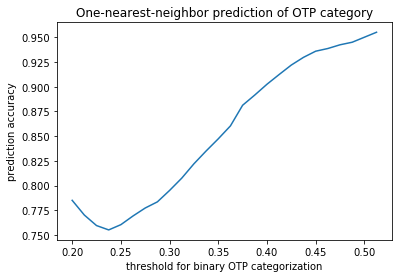

In [39]:
plt.plot(t1val,accuracy_s1)
plt.title('One-nearest-neighbor prediction of OTP category')
plt.ylabel('prediction accuracy')
plt.xlabel('threshold for binary OTP categorization')

In [85]:
knn = KNeighborsClassifier(n_neighbors=1)
recall_s1 = []
fo_s1 = []
#tt1val = (np.asarray(list(range(49))))*0.02+0.02
for i,t1 in enumerate(t1val):
    HDW_OTP['cat_otp_s'] = HDW_OTP['InflightOTP']  # column to hold categorical search values
    HDW_OTP.loc[HDW_OTP.cat_otp_s > t1, 'cat_otp_s'] = 1
    HDW_OTP.loc[HDW_OTP.cat_otp_s <= t1, 'cat_otp_s'] = 0
    y_otp_s = HDW_OTP['cat_otp_s'].as_matrix()
    y_otp_s = y_otp_s.astype(int)
    ys_train, ys_test = sklearn.model_selection.train_test_split(y_otp_s, test_size=0.2, random_state=64)
    knn.fit(encoded, ys_train)
    ys_pred = knn.predict(encoded_tst)
    recall_s1.append(metrics.recall_score(ys_test, ys_pred))
    tn, fp, fn, tp = metrics.confusion_matrix(ys_test, ys_pred).ravel()
    fo_s1.append(fp / (tn+fp))

In [50]:
t1val[-7]

0.4375

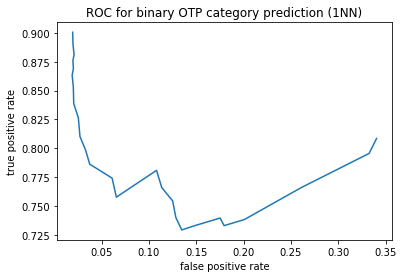

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.annotate('threshold = 0.4375', xy=(0.853, 0.0364), xytext=(0.85, 0.05),
#               arrowprops=dict(facecolor='black', shrink=0.01),
#            )
#plt.plot(fo_s1[12:],recall_s1[12:])
#plt.plot(fo_s1[-7],recall_s1[-7],'ro')
plt.plot(fo_s1,recall_s1)
plt.title('ROC for binary OTP category prediction (1NN)')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')

In [125]:
t2val = (np.asarray(list(range(99))))*0.01
#t1val = (np.asarray(list(range(26))))*0.0125+0.2

In [126]:
knn = KNeighborsClassifier(n_neighbors=1)
recall_s2 = []
fo_s2 = []
for i,t2 in enumerate(t2val):
    print(i,end='')
    HDW_OTP['cat_otp_s'] = HDW_OTP['InflightOTP']  # column to hold categorical search values
    HDW_OTP.loc[HDW_OTP.cat_otp_s > t2, 'cat_otp_s'] = 1
    HDW_OTP.loc[HDW_OTP.cat_otp_s <= t2, 'cat_otp_s'] = 0
    y_otp_s = HDW_OTP['cat_otp_s'].as_matrix()
    y_otp_s = y_otp_s.astype(int)
    ys_train, ys_test = sklearn.model_selection.train_test_split(y_otp_s, test_size=0.2, random_state=64)
    knn.fit(encoded, ys_train)
    ys_pred = knn.predict(encoded_tst)
    recall_s2.append(metrics.recall_score(ys_test, ys_pred))
    tn, fp, fn, tp = metrics.confusion_matrix(ys_test, ys_pred).ravel()
    fo_s2.append(fp / (tn+fp))

01234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798

In [127]:
ftyfty = [0,1]

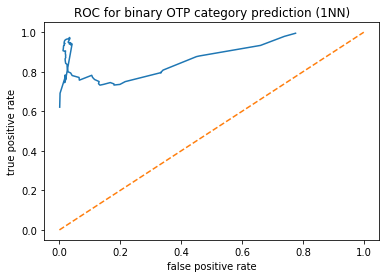

In [135]:
### fig = plt.figure()
ax = fig.add_subplot(111)
#ax.annotate('threshold = 0.4375', xy=(0.853, 0.0364), xytext=(0.85, 0.05),
#               arrowprops=dict(facecolor='black', shrink=0.01),
#            )
#plt.plot(fo_s1[12:],recall_s1[12:])
#plt.plot(fo_s1[-7],recall_s1[-7],'ro')
#plt.plot(fo_s2,recall_s2)
plt.plot(fo_s2[15:-9],recall_s2[15:-9])
#plt.plot(fo_s2[35],recall_s2[35],'ro')
plt.plot(ftyfty,ftyfty,'--')
plt.title('ROC for binary OTP category prediction (1NN)')
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')

In [62]:
accuracy_s22 = np.zeros([19,19])
for i in range(19):
    t1i = i*0.05
    for j in range(i+1,20):
        t2j = j*0.05
        HDW_OTP['cat_otp_s'] = HDW_OTP['InflightOTP']  # column to hold categorical search values
        HDW_OTP.loc[HDW_OTP.cat_otp_s > t2j, 'cat_otp_s'] = 2
        HDW_OTP.loc[(HDW_OTP.cat_otp_s > t1i) & (HDW_OTP.cat_otp_s <= t2j), 'cat_otp_s'] = 1
        HDW_OTP.loc[HDW_OTP.cat_otp_s <= t1i, 'cat_otp_s'] = 0
        y_otp_s = HDW_OTP['cat_otp_s'].as_matrix()
        y_otp_s = y_otp_s.astype(int)
        ys_train, ys_test = sklearn.model_selection.train_test_split(y_otp_s, test_size=0.2, random_state=64)
        knn.fit(encoded, ys_train)
        ys_pred = knn.predict(encoded_tst)
        accuracy_s22[i,j-1] = metrics.accuracy_score(ys_test, ys_pred)

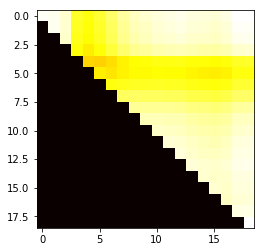

In [160]:
plt.imshow(accuracy_s22, cmap='hot', interpolation='nearest')
plt.show()

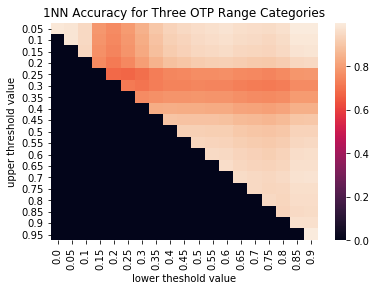

In [65]:
import seaborn as sns
xticks = 0.05*np.asarray(list(range(19)))
yticks = 0.05*np.asarray(list(range(1,20)))
ax = sns.heatmap(accuracy_s22, xticklabels=xticks, yticklabels=yticks)
plt.title('1NN Accuracy for Three OTP Range Categories')
plt.xlabel('lower theshold value')
plt.ylabel('upper threshold value')

In [163]:
accuracy_s22[8,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.89647577,  0.89194092,
        0.89388443,  0.89051568,  0.8880539 ,  0.87367194,  0.86810054,
        0.86175175,  0.87146929,  0.90023322,  0.90217673])

In [164]:
accuracy_s22[10,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.94324955,  0.93923296,  0.93625292,  0.92187095,  0.91616999,
        0.9098212 ,  0.91927961,  0.94804353,  0.94998704])

In [165]:
accuracy_s22[6,:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.761078  ,  0.77131381,  0.77947655,  0.77869914,
        0.78297486,  0.78064265,  0.77921741,  0.76626069,  0.7606893 ,
        0.7543405 ,  0.76405805,  0.79282197,  0.79476548])

In [79]:
knn = KNeighborsClassifier(n_neighbors=1)
accuracy_s33 = np.zeros([19,19])
t1 = 0.4
for i in range(19):
    t2i = t1+0.6*i*0.05
    for j in range(i+1,20):
        t3j = t1+0.6*j*0.05
        HDW_OTP['cat_otp_s'] = HDW_OTP['InflightOTP']  # column to hold categorical search values
        HDW_OTP.loc[HDW_OTP.cat_otp_s > t3j, 'cat_otp_s'] = 3
        HDW_OTP.loc[(HDW_OTP.cat_otp_s > t2i) & (HDW_OTP.cat_otp_s <= t3j), 'cat_otp_s'] = 2
        HDW_OTP.loc[(HDW_OTP.cat_otp_s > t1) & (HDW_OTP.cat_otp_s <= t2i), 'cat_otp_s'] = 1
        HDW_OTP.loc[HDW_OTP.cat_otp_s <= t1, 'cat_otp_s'] = 0
        y_otp_s = HDW_OTP['cat_otp_s'].as_matrix()
        y_otp_s = y_otp_s.astype(int)
        ys_train, ys_test = sklearn.model_selection.train_test_split(y_otp_s, test_size=0.2, random_state=64)
        knn.fit(encoded, ys_train)
        ys_pred = knn.predict(encoded_tst)
        accuracy_s33[i,j-1] = metrics.accuracy_score(ys_test, ys_pred)

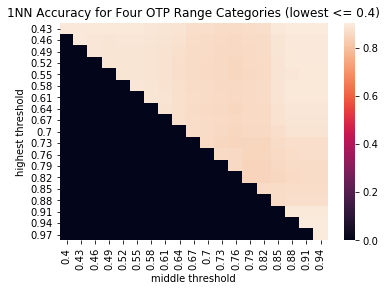

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
xticks = 0.05*np.asarray(list(range(19)))*0.6 + 0.4
yticks = 0.05*np.asarray(list(range(1,20)))*0.6 + 0.4
import seaborn as sns
ax = sns.heatmap(accuracy_s33, xticklabels=xticks, yticklabels=yticks)
plt.title('1NN Accuracy for Four OTP Range Categories (lowest <= 0.4)')
plt.xlabel('middle threshold')
plt.ylabel('highest threshold')

In [38]:
# t1 = 0.4, t2 = 0.55, t3 = 0.7
#   -> i = 5, j = 9
accuracy_s33[5,9]

0.86680487172842702

In [41]:
t1 = 0.4
t2 = 0.55
t3 = 0.7
HDW_OTP['cat_otp3'] = HDW_OTP['InflightOTP']
HDW_OTP.loc[HDW_OTP.cat_otp3 > t3, 'cat_otp3'] = 3
HDW_OTP.loc[(HDW_OTP.cat_otp3 > t2) & (HDW_OTP.cat_otp3 <= t3), 'cat_otp3'] = 2
HDW_OTP.loc[(HDW_OTP.cat_otp3 > t1) & (HDW_OTP.cat_otp3 <= t2), 'cat_otp3'] = 1
HDW_OTP.loc[HDW_OTP.cat_otp3 <= t1, 'cat_otp3'] = 0
y_otp3 = HDW_OTP['cat_otp3'].as_matrix()
y_otp3 = y_otp3.astype(int)
y3_train, y3_test = sklearn.model_selection.train_test_split(y_otp3, test_size=0.2, random_state=64)
knn.fit(encoded, y3_train)
y3_pred = knn.predict(encoded_tst)
accuracy3 = metrics.accuracy_score(y3_test, y3_pred)
confusion3 = metrics.confusion_matrix(y3_test, y3_pred)
print('Accuracy: ', accuracy3)
print()
print('Confusion matrix: ')
print(confusion3)

Accuracy:  0.866804871728

Confusion matrix: 
[[4255   81   20   17]
 [ 463  608   19    9]
 [ 162   34  686  192]
 [  10    4   17 1141]]
